<a href="https://colab.research.google.com/github/nekeal/mwsis/blob/master/%C4%86wiczenia_obliczenia_Bayesowskie_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
tfd = tfp.distributions
import pandas as pd

In [ ]:
tf.__version__, tfp.__version__

('2.8.2', '0.16.0')

# Generacja obserwacji


In [ ]:
N=2000
dt = tfd.Exponential(20.).sample(N)

In [ ]:
1/np.mean(dt)

19.788100386133973

# Model

$$\lambda \sim softplus(N(10,5))$$
$$\delta|\lambda \sim Exp(\lambda)$$
$$\lambda|\delta=?$$

In [ ]:
joint = tfd.JointDistributionNamed(dict(
    prior = tfd.TransformedDistribution(tfd.Normal(10., 5.), tfp.bijectors.Softplus()),
    delta = lambda prior:tfd.Sample(tfd.Exponential(prior), sample_shape=[N])
))

In [ ]:
joint.sample()


{'delta': <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([0.00581708, 0.1013495 , 0.8111846 , ..., 0.03042394, 0.0285845 ,
        0.10784871], dtype=float32)>,
 'prior': <tf.Tensor: shape=(), dtype=float32, numpy=8.802515>}

In [ ]:
def target_log_prob(Lambda):
  return joint.log_prob(prior=Lambda, delta=dt)

# MCMC

In [ ]:
hmc = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=target_log_prob,
    step_size=.1)

hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=hmc,
    bijector=[
        tfp.bijectors.Softplus(),  # s1
    ])

hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=100,
    target_accept_prob=.8)

joint_sample = joint.sample(10)
initial_state = [
    joint_sample['prior'],
]

In [ ]:
@tf.function(autograph=False, experimental_compile=True)
def run():
  return tfp.mcmc.sample_chain(
      num_results=500,
      current_state=initial_state,
      kernel=hmc,
      num_burnin_steps=100,
      trace_fn=lambda _, kr: kr)

samples, traces = run()
print('R-hat diagnostics: ', tfp.mcmc.potential_scale_reduction(samples))


R-hat diagnostics:  [<tf.Tensor: shape=(), dtype=float32, numpy=1.002804>]


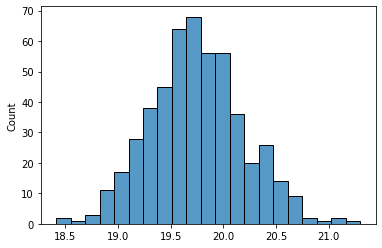

In [ ]:
sns.histplot(samples[0][:,0])


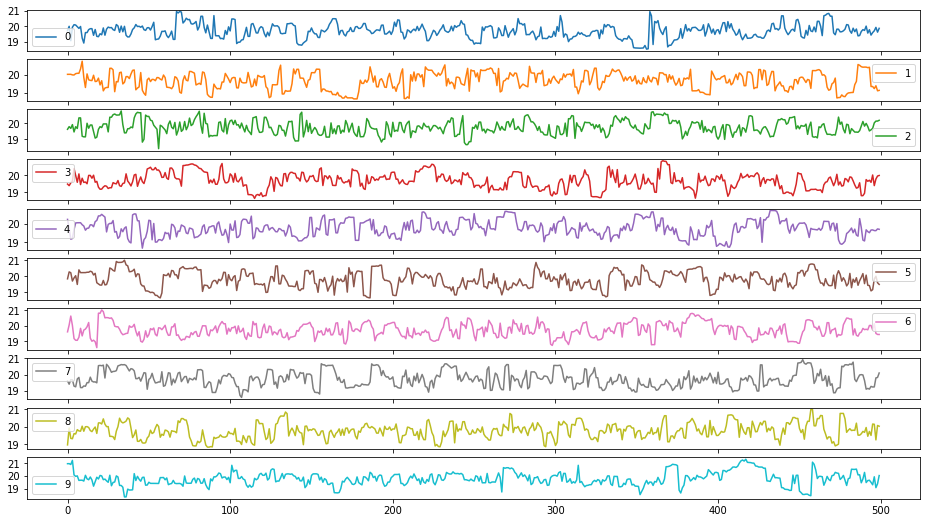

In [ ]:
pd.DataFrame(samples[0].numpy()).plot(subplots=True, figsize=(16,9));


In [ ]:
np.mean(samples[0], axis=0), np.std(samples[0], axis=0)

(array([19.683916, 19.75519 , 19.739916, 19.698515, 19.695375, 19.750235,
        19.792994, 19.755709, 19.713165, 19.711203], dtype=float32),
 array([0.45474133, 0.42513916, 0.4249095 , 0.47338468, 0.4116579 ,
        0.44668323, 0.46201855, 0.5026845 , 0.4561194 , 0.4345911 ],
       dtype=float32))

## Zadanie

Wyznaczyć rozklad sredniej zajetości systemu $M/M/1$ z $\mu=25$ dla wyestymowanego rozkladu $\lambda$

In [ ]:
#TODO

# VI

Nomalny

In [ ]:
q = tfd.Normal(loc=tf.Variable(50., name='q_loc'),
                 scale=tfp.util.TransformedVariable(1., tfp.bijectors.Softplus(),
                                                    name='q_scale'))


Lub Gamma

In [ ]:

# q = tfd.Gamma(concentration=tfp.util.TransformedVariable(1600., tfp.bijectors.Softplus()),
#               rate=tfp.util.TransformedVariable(160., tfp.bijectors.Softplus()))

In [ ]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob,
    surrogate_posterior=q,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=5000,
    sample_size=100)
print(q.mean(), q.stddev())

tf.Tensor(19.703066, shape=(), dtype=float32) tf.Tensor(0.3985489, shape=(), dtype=float32)


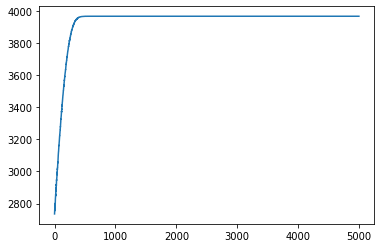

In [ ]:
plt.plot(-losses)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Krzysztof Rusek 2000, N(10,5)')

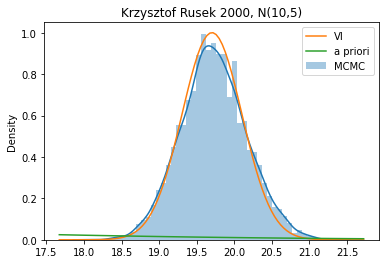

In [ ]:
sns.distplot(samples[0].numpy().flatten(), label="MCMC")
x= np.linspace(*plt.xlim(), 100)
y = q.prob(x)
sns.lineplot(x,y, label="VI")
sns.lineplot(x,joint.model['prior'].prob(x), label="a priori")
plt.title('Krzysztof Rusek 2000, N(10,5)')

~~Wnioskowanie wariacyjne jest wrażliwe na warunki poczatkowe. Zbadać dokładnosć dopasowania.~~

## Zadanie

Zabdać dopasowanie dla

a priori

- $softplus(N(20,5))$
- $softplus(N(30,5))$

i $N$

- 20
- 200
- 20000


# Zadanie

~~Zaprojektować  system kolejkowy w którym rozkład stacjonarny spełnia warunek $\pi_n\sim\frac{1}{n^4}\ n>0$ . Można zaobserwować, że symulując taki system próbkujemy liczby z rozkładu $\pi_n$ bez wyliczania stałej normalizacyjnej $\sum_{n}\pi_n$~~